## 1. Подготовка данных ##

#### 1.1. Установка библиотек, импорты ####

In [ ]:

!pip install nltk
!pip install pymystem3
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import networkx as nx
import numpy as np
import math
from pymystem3 import Mystem
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from matplotlib import cm




%matplotlib inline
sns.set(style="whitegrid")


mystem = Mystem()

#### 1.2. Подготовка датафрейма ####

In [ ]:
def cleaner(dataframe, exclude=None):
    if exclude is None:
        exclude = []
    for col in dataframe.columns:
        # Если столбец в списке исключённых — пропускаем его
        if col in exclude:
            continue


        if dataframe[col].dtype == 'object':
          dataframe[col] = (dataframe[col]
                              .astype(str)
                              .str.replace(r'\s+', ' ', regex=True)
                              .str.strip()
                              .str.lower())
          dataframe[col] = dataframe[col].replace('nan', np.nan)

    return dataframe

df = pd.read_excel('все_ассоциации_общий файл.xlsx')
df = cleaner(df)
df


,Стимулы,глаз,окно,берег,книга,месяц,орган,журнал,купить,солдат,...,исчезнуть,областной,последний,сложиться,продолжать,необходимый,сегодняшний,политический,рассказывать,правительство
0,NaN,стеклянный,открыто,высокий,настольная,май,бах,мурзилка,продать,удачи,...,навсегда,центр,день,деньгами,нести чушь,предмет,день,конгресс,сплетни,загадка
1,NaN,объектив реальности,рамка бытия,гармония,крепость культуры,циферблат ночи,механизм функционирования,not,not,not,...,призрак,центр,год,пазл,разговор,нужный,денб,скам,язык,государство
2,NaN,зрение,стекло,море,читать,май,сердце,новости,продукты,армия,...,невидимка,номер,день,во времени,рассказ,ингредиент,день,лозунг,историю,россии
3,NaN,зеленый,дверь,моря,писать,май,власти,моды,еду,служба,...,испариться,частный,первый,коробка,ждать,нужный,завтрашний,суд,молчать,надежда
4,NaN,чешется,сверкает,реки,интересная,новый,власти,глянцевый,мороженое,армия,...,пропасть,центр,крайний,в ящик,работу,важный,день,взгляд,иссторию,власть
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,испариться,региональный,крайний,совместиться,следовать дальше,нужный,свежий,политический взгляд,повествование,правительство страны
496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,из виду,центр,сезон,судьба,занятие,выбор,день,взгляд,история,президент
497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,навсегда,прокурор,день,вместе,делать,предмет,день,спор,история,страны
498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,навсегда,больница,герой,в 2 слоя,говорить,ингридиент,день,конфликт,анекдот,россии


## 2. Создаем базовый датафрейм c нужными показателями для дальнейшей обработки ##

#### 2.1. Формирование датафрейма для дальнейшей работы ####

Первичные данные после эксперимента необходимо обработать так, чтобы это было похоже на стандартную словарную статью в ассоциативных словарях. Для этого, в первую очередь, прохожу по каждому стимулу, нахожу совпадающие ассоциации и присваиваю им показатели абсолютной частоты (в рамках ассоциативного поля к каждому стимулу по-отдельности).

In [ ]:
df_frequencies = []

for stimulus in df.columns:
    associations = df[stimulus].dropna()
    value_counts = associations.value_counts()

# Меняю расположение колонок в файле. Вертикальный формат с повторением стимулов будет удобней для дальнейшей обработки.

    freq_df = pd.DataFrame({
        'стимул': stimulus,
        'ассоциация': value_counts.index,
        'частота': value_counts.values
    })
    df_frequencies.append(freq_df)

df_frequencies = pd.concat(df_frequencies, ignore_index=True)

df_frequencies.to_excel('обработанные_ассоциации_общий.xlsx', index=False)

display(df_frequencies.head(10))

,стимул,ассоциация,частота
0,глаз,зрение,69
1,глаз,зрачок,29
2,глаз,очки,27
3,глаз,око,26
4,глаз,голубой,24
5,глаз,алмаз,20
6,глаз,видеть,15
7,глаз,нос,14
8,глаз,орган,13
9,глаз,яблоко,13


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


#### 2.2. Лемматизация и POS-тегинг ####

Для анализа всей сформированной ассоциативно-вербальной сети производим лемматизацию ассоциаций. Этот шаг потом позволит рассмотреть повторяющиеся ассоциации во всей сети, выявить самые частотные. Частеречная разметка необходима, чтобы проводить дальнейшие исследования ассоциативных полей с учетом их грамматических особенностей.

In [ ]:
#  новый датафрейм, так как в сохраненном файле нужно было внести изменения.
df2 = pd.read_excel('обработанные_ассоциации_общий_итог.xlsx')
df2

,стимул,ассоциация,частота
0,глаз,зрение,69
1,глаз,зрачок,29
2,глаз,очки,27
3,глаз,око,26
4,глаз,голубой,24
...,...,...,...
77335,правительство,серьезное,1
77336,правительство,народ,1
77337,правительство,боссы,1
77338,правительство,правительство страны,1


In [ ]:
# функция для лемматизации и частей речи, так как части речи надо будет определять и для стимулов и для ассоциаций.
def lemmatize_and_tag(text):
    if pd.isna(text) or str(text).strip() == '':  # для пустых ячеек
        return "", ""
    analysis = mystem.analyze(str(text))
    lemmas, pos_tags = [], []
    for item in analysis:
        if 'analysis' in item and item['analysis']:
            lemmas.append(item['analysis'][0]['lex'])
            grammar = item['analysis'][0]['gr']
            pos = grammar.split(',')[0].split('=')[0]
            pos_tags.append(pos)
    return ' '.join(lemmas), '+'.join(pos_tags) # если два слова в ассоциации, то ч.р. прописываю через +

# Для ассоциаций
df2[['лемма', 'часть речи ассоциации']] = df2['ассоциация'].apply(
    lambda x: pd.Series(lemmatize_and_tag(x))
)

# Для стимулов (делаю отдельно, так стимулы повторяются)
stimuli_unique = pd.DataFrame({'стимул': df2['стимул'].unique()})
stimuli_unique['часть речи стимула'] = stimuli_unique['стимул'].apply(
    lambda x: lemmatize_and_tag(x)[1].split('+')[0]
) # среди стимулов есть двойные, это, как правило, две формы глаголов, нам не надо, чтобы тут двойная часть речи через плюс была


df2 = df2.merge(stimuli_unique, on='стимул', how='left')

order = ['стимул', 'часть речи стимула', 'ассоциация', 'частота', 'лемма', 'часть речи ассоциации']
df2 = df2[order]

display(df2.head())

,стимул,часть речи стимула,ассоциация,частота,лемма,часть речи ассоциации
0,глаз,S,зрение,69,зрение,S
1,глаз,S,зрачок,29,зрачок,S
2,глаз,S,очки,27,очки,S
3,глаз,S,око,26,око,S
4,глаз,S,голубой,24,голубой,A


In [ ]:
df2 = cleaner(df2, exclude=['часть речи стимула', 'часть речи ассоциации'])

## 3. Обработка лемматизированных ассоциаций ##

#### 3.1. Частоты лемм ####

Пересчитываем частоты лемматизированных ассоциаций: учитываем частоту каждой словоформы.

In [ ]:
df_lemmas = df2.groupby(['стимул', 'лемма'], as_index=False)['частота'].sum()

df_lemmas = df_lemmas.sort_values(['стимул', 'частота'], ascending=[True, False])
display(df_lemmas.head().style.hide(axis='index'))

стимул,лемма,частота
автомобиль,машина,63
автомобиль,колесо,24
автомобиль,дорога,22
автомобиль,руль,19
автомобиль,транспорт,19


In [ ]:
df_lemmas = cleaner (df_lemmas)

 #### 3.2. Пересечения лемм ####

Смотрим, какие леммы приводились к разным стимулам. Часто повторяющиеся леммы-ассоциации - это ядро ассоциативно-вербальной сети.

In [ ]:
# Не учитываю пустые значения (это то, что не смог лемматизировать Mystem, это надо будет потом отдельно проверять)
clean_lemmas = df_lemmas[
    (df_lemmas['лемма'].str.strip() != '') &
    (df_lemmas['лемма'].notna())
].copy()

# Поиск совпадающих лемм у разных стимулов
shared_lemmas = clean_lemmas.groupby('лемма')['стимул'].agg( #группируем все совпадающие леммы
    Количество_стимулов='nunique', #считаем уникальные
    Список_стимулов=lambda x: ', '.join(sorted(x.unique())) # берем только уникальные, сортируем и склеиваем стимулы в одну строку через запятую
).reset_index()


shared_lemmas = shared_lemmas[shared_lemmas['Количество_стимулов'] > 1].sort_values('Количество_стимулов', ascending=False)
shared_lemmas.columns = ['лемма', 'количество стимулов', 'список стимулов']

display(shared_lemmas.head().style.hide(axis='index'))

лемма,количество стимулов,список стимулов
человек,291,"автор, американский, бедный, белый, ближайший, боевой, больной, больший, бояться, брат, будущий, бывший, быть, вечный, видеть, военный, воздушный, возникать, возраст, волос, врач, встретиться, вызывать, высокий, генерал, глаз, глупый, глядеть, голова, голос, голубой, горный, город, городской, господин, готовый, гражданин, группа, губа, давать, данные, девочка, девушка, дерево, деревянный, дешевый, директор, длинный, добрый, доктор, домашний, достать, дочь, древний, духовный, ждать, железный, жена, женщина, жесткий, забыть, завод, закрытый, зал, занимать, занять, западный, заставить, звать, звонить, зеленый, земля, земной, знакомый, изменить, иностранный, использовать, история, казаться, каменный, качество, кивнуть, класс, команда, коммерческий, компания, конечный, конкретный, короткий, крайний, крикнуть, крупный, левый, легкий, лесной, лицо, лишний, маленький, малый, мальчик, мама, мать, мелкий, мера, мертвый, местный, метод, мешать, миллион, министр, модель, молчать, московский, муж, мужчина, мягкий, назвать, называть, найти, народ, научный, находиться, начальник, небольшой, необходимый, низкий, нормальный, образ, обратиться, обращаться, общественный, общество, общий, объект, объяснять, обычный, одинаковый, оказаться, оказываться, определенный, орган, организация, основной, оставаться, оставить, остаться, отдельный, отец, открытый, относиться, очередь, память, папа, парень, партийный, партия, писатель, площадь, поговорить, поднять, подойти, позволить (позволять), позвонить, позиция, показать, показаться, пол, политика, политический, половина, положение, понимать, попросить, последний, последующий, поставить, постоянный, похожий, появляться, правительство, православный, предприятие, председатель, предыдущий, президент, привести, приводить, привыкнуть, прийти, принять, природа, приходиться, провести, промышленный, просить, пространство, процент, прошлый, прямой, пустой, путь, пьяный, рабочий, равный, рад, разговор, различный, разный, ребенок, регион, речь, рисунок, род, роман, рост, рука, руководитель, рынок, ряд, самолет, светлый, связать, связь, святой, сельский, серый, синий, система, слабый, сложный, случайный, слушать, слышать, собрать, совет, советский, совместный, современный, согласиться, сознание, солдат, состав, состояние, союз, спина, спокойный, спросить, средний, становиться, старик, старый, стать, стена, структура, судьба, сухой, считать, считаться, сын, твердый, темный, теплый, тип, тихий, тонкий, трудовой, тяжелый, увидеть, удобный, узкий, улица, услышать, устроить, учебный, физический, хватать, хозяин, холодный, художник, церковь, частный, человек, человеческий, черный, число, чистый, чужой, широкий, экономический, являться, язык"
дом,217,"американский, бедный, белый, ближайший, больной, больший, брат, будущий, бывший, быть, вечер, вечный, вещь, видеть, воздушный, войти, встретиться, входить, выйти, высокий, выходить, голубой, горный, город, городской, готовить, готовый, дверь, двор, дерево, деревянный, держать, детский, дешевый, дойти, домашний, древний, духовный, есть, ехать, ждать, жена, женщина, забыть, завод, зайти, закрытый, закрыть, зал, звать, зеленый, земля, земной, идти, кабинет, каменный, квартира, китайский, коммерческий, комната, конкретный, крайний, круглый, крупный, купить, левый, лес, лесной, лишний, магазин, маленький, малый, мама, мать, медицинский, мелкий, мертвый, местный, место, миллион, момент, московский, муж, найти, находиться, небольшой, низкий, номер, нормальный, областной, общественный, общий, объект, обычный, одинаковый, оказаться, оказываться, окно, определенный, основа, основной, оставаться, оставить, остановиться, остаться, отдельный, отец, открытый, открыть, относиться, папа, передний, площадь, подать, поднять, подойти, поехать, позвонить, поздний, показать, пол, поле, половина, положение, помнить, попасть, пора, порядок, последний, посмотреть, постоянный, похожий, православный, предприятие, председатель, предыдущий, президент

In [ ]:
shared_lemmas = cleaner(shared_lemmas)

## 4. Статистика: подсчет базовых показателей для ассоциативного словаря, анализ частей речи, TF-IDF, лексическое разнообразие, сила связи ядерных ассоциаций ##

#### 4.1. Количественная характеристика стимулов ####

Для словарных статей ассоциативных словарей, как правило, приводятся следующие количественные показатели к каждому стимулу: а) всего ответов, б) количество различных ассоциаций, в) количество единичных ассоциаций; г) количество отказов.
Формула лексического разнообразию берется из трудов Ю.Н. Караулова, это общепринятая формула в подобных исследованиях.

In [ ]:

stats_list = []

for slovo, sub_df in df2.groupby('стимул'):
    total = sub_df['частота'].sum() # всего ответов
    refusals = sub_df[sub_df['ассоциация'] == 'not']['частота'].sum() # сколько отказов
    valid_rows = sub_df[sub_df['ассоциация'] != 'not'] # только ассоциации, без отказов
    distinct = len(valid_rows) # считаем уникальные ассоциации (без отказов)
    singles = len(valid_rows[valid_rows['частота'] == 1]) # одиночные ассоциации

    stats_list.append({
        'стимул': slovo,
        'часть речи стимула': sub_df['часть речи стимула'].iloc[0], # не берем все слов, так как стимулы повторяются
        'всего': total,
        'различные ассоциации': distinct,
        'одиночные ассоциации': singles,
        'отказы': refusals,
        'лексическое разнообразие': round(distinct / total, 3) if total > 0 else 0 # по Караулову
    })

df_summary = pd.DataFrame(stats_list)

display(df_summary.sort_values('лексическое разнообразие', ascending=False).head().style.hide(axis='index'))



стимул,часть речи стимула,всего,различные ассоциации,одиночные ассоциации,отказы,лексическое разнообразие
система,S,500,285,223,1,0.570000
позиция,S,500,276,200,1,0.552000
проект,S,500,274,198,1,0.548000
структура,S,500,264,186,1,0.528000
использовать,V,500,263,203,1,0.526000


#### 4.2. Статистика по частям речи ####

Далее необходимо сделать расчеты касательно частеречных характеристик ассоциаций. В ответах респондентов встречаются ассоциации более чем из одного слова, для таких слов мы проставляли теги частей речи через +, в этой статистики все "плюсовые" теги будем считать в одной группе, это будут ассоциации n-граммы. Проценты считаются только для слов, к которым при морфологическом анализе была указана часть речи.

In [ ]:
# Статистика по частям речи ассоциаций
# собираем список всех уникальных одиночных тегов (S, V, A и т.д.)
all_pos = [tag for tag in df2['часть речи ассоциации'].unique() if "+" not in str(tag) and tag != ""]
# не считаю теги для более чем одного слова (исключаю с +) и исключаем пустые ячейки
pos_data = []
for slovo, sub_df in df2.groupby('стимул'):
    meaningful = sub_df[sub_df['часть речи ассоциации'] != ""] #берем только, те у которых ч.р. определена
    total_m = meaningful['частота'].sum() # считаем их общую частоту

    res = {'стимул': slovo}
    for tag in all_pos:
        count = sub_df[sub_df['часть речи ассоциации'] == tag]['частота'].sum()
        res[f'{tag}_%'] = round(count / total_m * 100, 2) if total_m > 0 else 0
    pos_data.append(res)

df_pos_distribution = pd.DataFrame(pos_data)
# Объединяем со сводной статистикой
df_summary = df_summary.merge(df_pos_distribution, on='стимул')
display(df_summary.head())

,стимул,часть речи стимула,всего,различные ассоциации,одиночные ассоциации,отказы,лексическое разнообразие,S_%,A_%,V_%,...,ADV_%,NUM_%,PART_%,APRO_%,INTJ_%,ANUM_%,ADVPRO_%,CONJ_%,COM_%,PR_%
0,автомобиль,S,490,186,121,1,0.380,78.53,12.88,3.89,...,0.2,0.0,0.0,0.41,0.0,0.0,0.0,0.0,0.0,0.0
1,автор,S,488,152,103,0,0.311,90.16,6.15,1.64,...,0.2,0.0,0.0,0.00,0.0,0.0,0.0,0.2,0.0,0.0
2,американский,A,498,146,105,0,0.293,90.16,7.03,0.20,...,0.0,0.0,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0
3,анализ,S,500,190,145,1,0.380,79.16,15.23,1.40,...,0.4,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.2
4,английский,A,499,87,66,0,0.174,87.75,8.84,1.00,...,0.4,0.0,0.6,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_summary = cleaner(df_summary, exclude=['часть речи стимула'])

Рассчитываем среднее по лексическому разнообразию и медиану. Смотрим отличия среднего лексического разнообразия стимулов разных частей речи от общего среднего.

In [ ]:
#  среднее значение по всем стимулам
mean_ttr = df_summary['лексическое разнообразие'].mean()

print(f"Среднее лексическое разнообразие для всего списка стимулов: {mean_ttr:.3f}")

#  медиана
median_ttr = df_summary['лексическое разнообразие'].median()
print(f"Медиана лексического разнообразия: {median_ttr:.3f}")

# среднее л.р. по частям речи стимулов
pos_mean = df_summary.groupby('часть речи стимула')['лексическое разнообразие'].mean().sort_values(ascending=False).reset_index()

print("Среднее лексическое разнообразие в зависимости от ч.р.:")

for index, row in pos_mean.iterrows():

    diff = row['лексическое разнообразие'] - mean_ttr

    mark = "выше среднего" if diff > 0 else "ниже среднего"

    print(f"- {row['часть речи стимула']}: {row['лексическое разнообразие']:.3f} ({mark})")

Среднее лексическое разнообразие для всего списка стимулов: 0.314
Медиана лексического разнообразия: 0.310
Среднее лексическое разнообразие в зависимости от ч.р.:
- V: 0.339 (выше среднего)
- S: 0.324 (выше среднего)
- A: 0.273 (ниже среднего)


#### 4.3. Анализ ядерных ассоциаций ####

Формируем новый датафрейм с ядерными ассоциациями. Рассчитываем силу связи.

In [ ]:

# сортировка  по стимулу в алфавитном порядке, затем по частоте (убывание)
df_sorted = df2.sort_values(['стимул', 'частота'], ascending=[True, False])

#  нужна именно словесная ассоциация

df_no_refusals = df_sorted[~df_sorted['ассоциация'].isin(['not'])]

# первую строку для каждого стимула (где самая частотная ассоциация)
df_strongest = df_no_refusals.drop_duplicates('стимул').copy()

# сила связи в процентах
# общее число ответов для каждого стимула из df_summary
if 'df_summary' in locals():
    #
    stats_subset = df_summary[['стимул', 'всего']]
    df_strongest = pd.merge(df_strongest, stats_subset, on='стимул', how='left')

    # частота этой ассоциации / всего ответов на стимул
    df_strongest['сила связи %'] = (
        (df_strongest['частота'] / df_strongest['всего']) * 100
    ).round(2)

cols_order = ['стимул', 'часть речи стимула', 'ассоциация', 'часть речи ассоциации', 'частота', 'сила связи %']
df_strongest = df_strongest[[c for c in cols_order if c in df_strongest.columns]]


df_strongest

,стимул,часть речи стимула,ассоциация,часть речи ассоциации,частота,сила связи %
0,автомобиль,S,машина,S,63,12.86
1,автор,S,книга,S,109,22.34
2,американский,A,пирог,S,81,16.27
3,анализ,S,крови,S,101,20.20
4,английский,A,язык,S,327,65.53
...,...,...,...,...,...,...
492,экономика,S,деньги,S,82,16.43
493,экономический,A,кризис,S,131,26.20
494,являться,V,быть,V,77,15.43
495,язык,S,русский,S,146,29.26


In [ ]:
df_strongest = cleaner (df_strongest, exclude=['часть речи стимула', 'часть речи ассоциации'])

#### 4.4. TF-IDF ассоциативного поля ####

Рассчитываем TF-IDF. Формируем датафрейм только с уникальными или же самыми характерными ассоциациями-леммами для стимулов.

In [ ]:

# Помогал ИИ

pivot = df_lemmas.pivot_table(index='стимул', columns='лемма', values='частота', fill_value=0)

X_counts = pivot.values.astype(np.float64)  # матрица с частотами
transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=False)
X_tfidf = transformer.fit_transform(X_counts)


max_indices = X_tfidf.argmax(axis=1).A1
max_values = X_tfidf.max(axis=1).toarray().flatten()


stimuli = pivot.index.tolist()
top_lemms = [pivot.columns[i] for i in max_indices]

df_tfidf_correct = pd.DataFrame({
    'стимул': stimuli,
    'характерная лемма': top_lemms,
    'TF-IDF': np.round(max_values, 4)
})

display(df_tfidf_correct.head(20))

,стимул,характерная лемма,TF-IDF
0,автомобиль,машина,0.5998
1,автор,книга,0.8212
2,американский,пирог,0.6919
3,анализ,кровь,0.9038
4,английский,язык,0.9899
5,банк,деньги,0.8128
6,бедный,богатый,0.5584
7,белый,снег,0.8182
8,берег,море,0.6938
9,ближайший,магазин,0.6536


In [ ]:
df_tfidf = cleaner (df_tfidf)


## 5. Визуализация ##

Облако слов для лемм

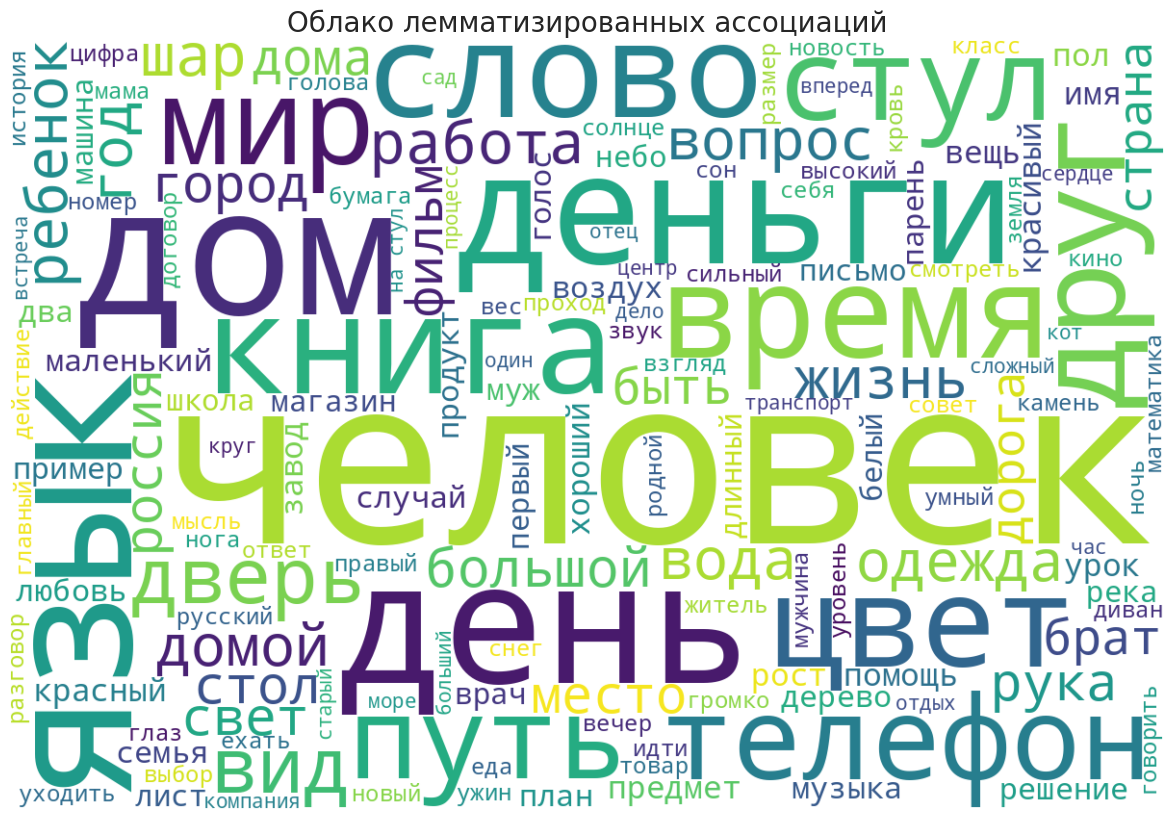

In [ ]:
top_lemmas = df_lemmas.groupby('лемма')['частота'].sum().to_dict()

wordcloud = WordCloud(
    width=1200,
    height=800,
    background_color='white',
    colormap='viridis',
    max_words=150
).generate_from_frequencies(top_lemmas)


plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако лемматизированных ассоциаций', fontsize=20)
plt.show()


wordcloud.to_file("wordcloud_associations.png")

График, демонстрирующий распределение коэффициента разнообразия

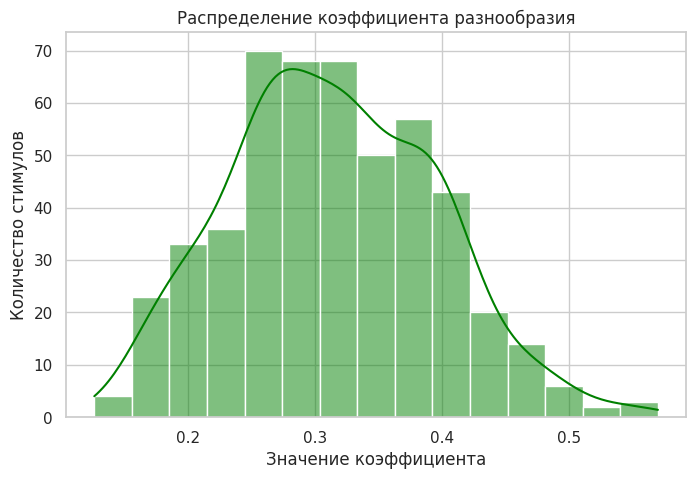

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_summary['лексическое разнообразие'], bins=15, kde=True, color='green')
plt.title('Распределение коэффициента разнообразия')
plt.xlabel('Значение коэффициента')
plt.ylabel('Количество стимулов')
plt.savefig('распределение ttr.png', dpi=300, bbox_inches='tight')
plt.show()

Построим график для 10 стимулов с самым высоким TTR и с самым низким. И сравним со средним показателем по всем словам.

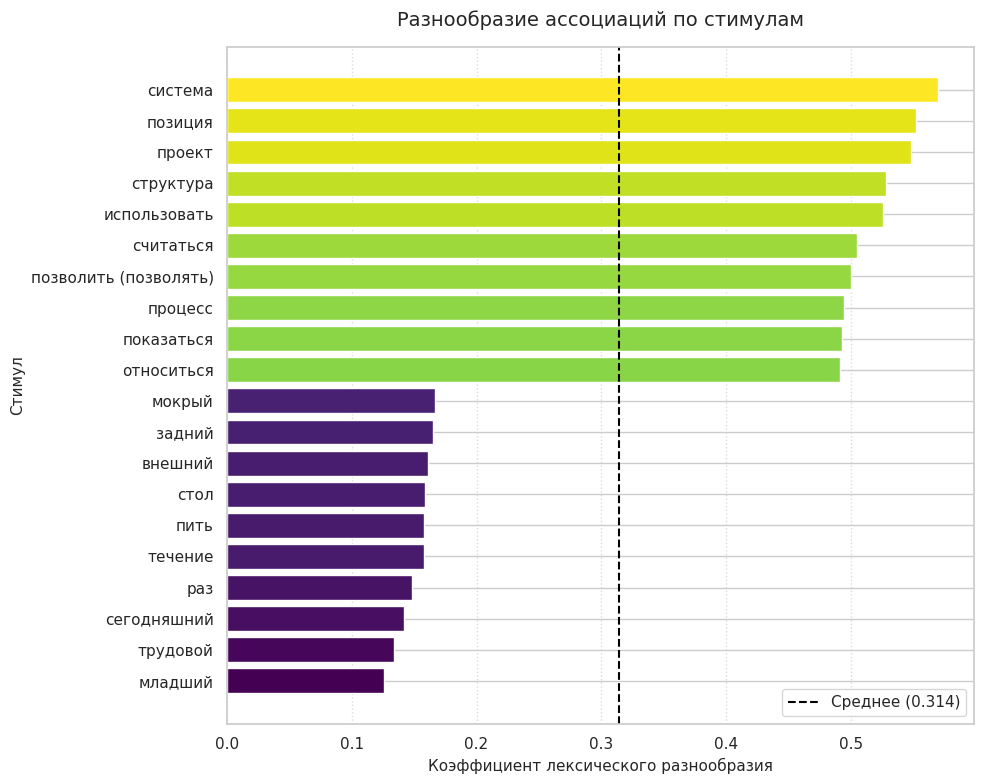

In [ ]:
#оформлять помогал ИИ


top_diverse = df_summary.nlargest(10, 'лексическое разнообразие')
bottom_diverse = df_summary.nsmallest(10, 'лексическое разнообразие')
combined = pd.concat([top_diverse, bottom_diverse]).sort_values('лексическое разнообразие')


plt.figure(figsize=(10, 8))

norm = plt.Normalize(combined['лексическое разнообразие'].min(), combined['лексическое разнообразие'].max())
colors = cm.viridis(norm(combined['лексическое разнообразие']))

plt.barh(combined['стимул'], combined['лексическое разнообразие'], color=colors)

mean_val = df_summary['лексическое разнообразие'].mean()
plt.axvline(mean_val, color='black', linestyle='--', linewidth=1.5, label=f'Среднее ({mean_val:.3f})')

plt.title('Разнообразие ассоциаций по стимулам', fontsize=14, pad=15)
plt.xlabel('Коэффициент лексического разнообразия', fontsize=11)
plt.ylabel('Стимул', fontsize=11)
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.savefig('разнообразие_топ.png', dpi=300, bbox_inches='tight')
plt.show()

Рассмотрим взаимосвязь частеречнх характеристик стимула и частеречных характеристик ассоциаиций.

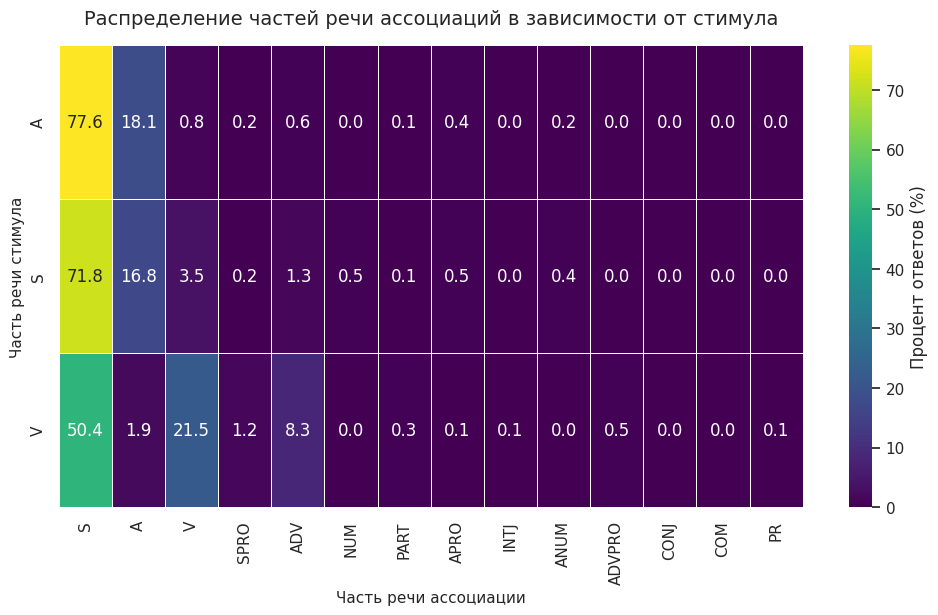

In [ ]:
#  список из колонок с процентами частей речи (в БД они заканчиваются на _%)
pos_percent_cols = [i for i in df_summary.columns if i.endswith('_%')] # попробовала метод  endswith()

# группировка в зависимости от части речи стимула и берем среднее по этим колонкам
heatmap_data = df_summary.groupby('часть речи стимула')[pos_percent_cols].mean()


heatmap_data.columns = [c.replace('_%', '') for c in heatmap_data.columns]

plt.figure(figsize=(12, 6))

sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='viridis',
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Процент ответов (%)'}
)

plt.title('Распределение частей речи ассоциаций в зависимости от стимула', fontsize=14, pad=15)
plt.ylabel('Часть речи стимула', fontsize=11)
plt.xlabel('Часть речи ассоциации', fontsize=11)
plt.savefig('pos.png', dpi=300, bbox_inches='tight')
plt.show()

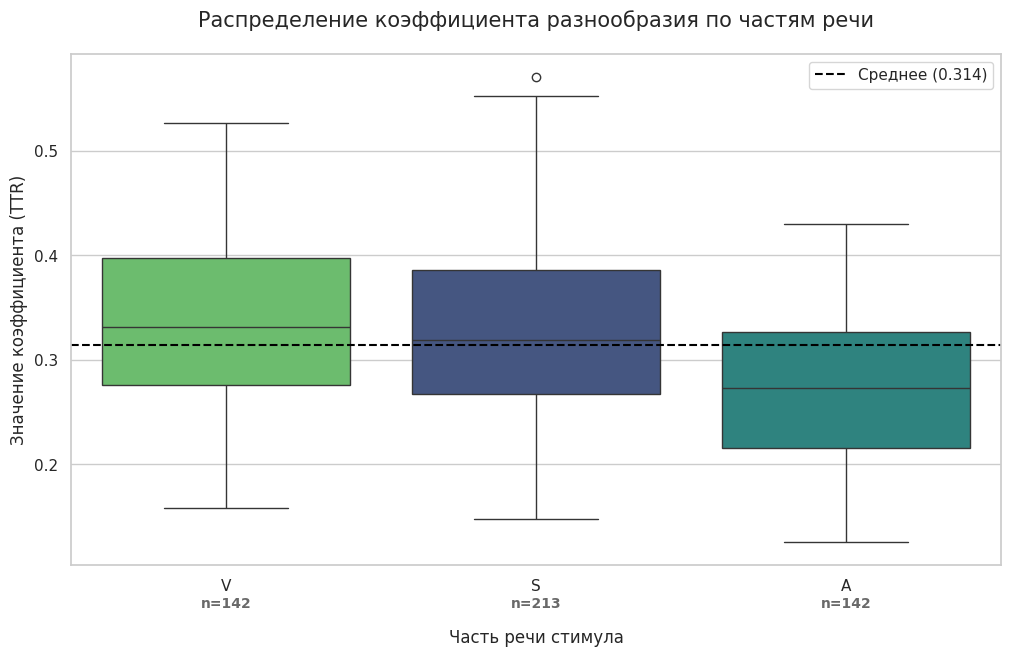

In [ ]:

# Этот график помогал строить ИИ


plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# порядок по медиане
order = df_summary.groupby('часть речи стимула')['лексическое разнообразие'].median().sort_values(ascending=False).index

ax = sns.boxplot(
    data=df_summary,
    x='часть речи стимула',
    y='лексическое разнообразие',
    order=order,
    hue='часть речи стимула',
    palette='viridis',
    legend=False
)


mean_val = df_summary['лексическое разнообразие'].mean()
plt.axhline(mean_val, color='black', linestyle='--', label=f'Среднее ({mean_val:.3f})')


plt.title('Распределение коэффициента разнообразия по частям речи', fontsize=15, pad=20)
plt.ylabel('Значение коэффициента (TTR)', fontsize=12)


plt.xlabel('Часть речи стимула', fontsize=12, labelpad=25)

# n=... под осью
for i, pos in enumerate(order):
    count = len(df_summary[df_summary['часть речи стимула'] == pos])
    plt.text(i, plt.gca().get_ylim()[0] - 0.03, f'n={count}',
             ha='center', va='top', fontsize=10, color='dimgray', fontweight='bold')

plt.legend(loc='upper right')


plt.subplots_adjust(bottom=0.15)

plt.savefig('boxplot_ttr_pos.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Выводы на экран ##

Посмотрим стимулы с самым высоким и низким лексическим разнообразием.

In [ ]:
# Топ-20 стимулов с высоким л. разнообразием
top_20 = df_summary.nlargest(20, 'лексическое разнообразие')[['стимул', 'лексическое разнообразие', 'различные ассоциации', 'всего']]

print(" ТОП-20 С ВЫСОКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ")
display(top_20.head(20).style.hide(axis='index'))



 ТОП-20 С ВЫСОКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ


стимул,лексическое разнообразие,различные ассоциации,всего
система,0.570000,285,500
позиция,0.552000,276,500
проект,0.548000,274,500
структура,0.528000,264,500
использовать,0.526000,263,500
считаться,0.505000,252,499
позволить (позволять),0.500000,239,478
процесс,0.494000,247,500
показаться,0.493000,246,499
относиться,0.491000,245,499


In [ ]:
#Топ-20 стимулов с никзим разнообразием
bottom_20 = df_summary.nsmallest(20, 'лексическое разнообразие')[['стимул', 'лексическое разнообразие', 'различные ассоциации', 'всего']]


print("ТОП-20 С НИЗКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ")
display(bottom_20.head(20).style.hide(axis='index'))

ТОП-20 С НИЗКИМ ЛЕКСИЧЕСКИМ РАЗНООБРАЗИЕМ


стимул,лексическое разнообразие,различные ассоциации,всего
младший,0.126000,60,478
трудовой,0.134000,67,500
сегодняшний,0.142000,71,500
раз,0.148000,74,499
пить,0.158000,79,499
течение,0.158000,79,500
стол,0.159000,78,490
внешний,0.161000,80,498
задний,0.165000,79,478
мокрый,0.167000,83,498


Стимулы с самым большим количеством одиночных ассоциаций и с минимальным.

In [ ]:
# нужные колонки сортируются по количеству одиночных ассоциаций
top_20_singles = df_summary[['стимул', 'одиночные ассоциации', 'всего']].copy()

top_20_singles = top_20_singles.sort_values('одиночные ассоциации', ascending=False).head(20)

top_20_singles.index = range(1, 21)

print("ТОП-20 СТИМУЛОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ")
display(top_20_singles)

ТОП-20 СТИМУЛОВ С НАИБОЛЬШИМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ


,стимул,одиночные ассоциации,всего
1,система,223,500
2,использовать,203,500
3,позиция,200,500
4,проект,198,500
5,считаться,186,499
6,структура,186,500
7,общество,186,500
8,процесс,185,500
9,показаться,185,499
10,оказываться,183,498


In [ ]:
bottom_20_singles = df_summary[['стимул', 'одиночные ассоциации', 'всего']].copy()
bottom_20_singles = bottom_20_singles.sort_values('одиночные ассоциации', ascending=True).head(20)
bottom_20_singles.index = range(1, 21)

print("ТОП-20 СТИМУЛОВ С МИНИМАЛЬНЫМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ")
display(bottom_20_singles)

ТОП-20 СТИМУЛОВ С МИНИМАЛЬНЫМ КОЛИЧЕСТВОМ ОДИНОЧНЫХ АССОЦИАЦИЙ


,стимул,одиночные ассоциации,всего
1,месяц,40,488
2,стол,44,490
3,младший,44,478
4,мокрый,44,498
5,желтый,45,498
6,конечный,49,500
7,старший,49,498
8,пить,49,499
9,сегодняшний,50,500
10,холодный,50,478


Ассоциативные пары с самой сильной связью.

In [ ]:

top_20_nuclear_pairs = df_strongest[['стимул', 'ассоциация', 'частота', 'сила связи %']].copy()

top_20_nuclear_pairs = top_20_nuclear_pairs.sort_values('частота', ascending=False).head(20)

top_20_nuclear_pairs.index = range(1, 21)

print("ТОП-20 САМЫХ СИЛЬНЫХ АССОЦИАТИВНЫХ ПАР (ЯДРА СЕТИ)")
display(top_20_nuclear_pairs)

ТОП-20 САМЫХ СИЛЬНЫХ АССОЦИАТИВНЫХ ПАР (ЯДРА СЕТИ)


,стимул,ассоциация,частота,сила связи %
1,немецкий,язык,353,70.60
2,сегодняшний,день,329,65.80
3,английский,язык,327,65.53
4,раз,два,316,63.33
5,внешний,вид,295,59.24
6,французский,язык,288,57.83
7,иностранный,язык,277,57.95
8,младший,брат,265,55.44
9,китайский,язык,263,55.02
10,воздушный,шар,262,52.61


## Дополнительно: сетевой анализ ##

Строится однодольная проекция двудольного графа. Узлами будут стимулы. Ребра - общие ассоциации.

In [ ]:
#код помогал писать ИИ, методы брала из разных статей адоптировала под свои задачи

stimulus_N = df2.groupby('стимул')['частота'].sum().to_dict()
freq_map = df2.set_index(['стимул', 'лемма'])['частота'].to_dict()

G2 = nx.Graph()

# пересечения из shared_lemmas
for _, row in shared_lemmas.iterrows():
    lemma = row['лемма']
    stims = [s.strip() for s in str(row['список стимулов']).split(',')]

    # без слишком общих лемм
    if len(stims) > 15:
        continue

    for i in range(len(stims)):
        for j in range(i + 1, len(stims)):
            s1, s2 = stims[i], stims[j]

            # частоты
            f_ap = freq_map.get((s1, lemma), 0)
            f_bp = freq_map.get((s2, lemma), 0)
            min_freq = min(f_ap, f_bp)

            if min_freq > 0:
                if G2.has_edge(s1, s2):
                    G2[s1][s2]['sum_min'] += min_freq
                else:
                    G2.add_edge(s1, s2, sum_min=min_freq)

# расчет коэффициента Диза
for u, v, d in list(G2.edges(data=True)):
    Nu = stimulus_N.get(u)
    Nv = stimulus_N.get(v)

    if Nu and Nv:
        denominator = math.sqrt((2 * Nu) * (2 * Nv))
        G2[u][v]['weight'] = d['sum_min'] / denominator
    else:
        G2[u][v]['weight'] = 0

G2.remove_edges_from([(u, v) for u, v, d in G2.edges(data=True) if d.get('weight', 0) == 0])

print(f"Узлов: {G2.number_of_nodes()}, Ребер: {G2.number_of_edges()}")



Узлов: 497, Ребер: 47461


In [ ]:
#фильтрация
threshold_k = 0.016
G_final = G2.copy()
G_final.remove_edges_from([(u, v) for u, v, d in G_final.edges(data=True) if d.get('weight', 0) < threshold_k])
G_final.remove_nodes_from(list(nx.isolates(G_final)))

print(f"После фильтрации осталось: {G_final.number_of_nodes()} узлов и {G_final.number_of_edges()} ребер.")

После фильтрации осталось: 340 узлов и 366 ребер.


In [ ]:

edge_data = []
for u, v, d in G_final.edges(data=True):
    edge_data.append({
        'Стимул 1': u,
        'Стимул 2': v,
        'Коэффициент Диза': round(d['weight'], 4),
        'Сумма миним. частот': d['sum_min']
    })

df_top_edges = pd.DataFrame(edge_data).sort_values('Коэффициент Диза', ascending=False)

print("ТОП-20 самых сильных ассоциативных связей по Дизу:")
display(df_top_edges.head(20).style.hide(axis='index'))

ТОП-20 самых сильных ассоциативных связей по Дизу:


Стимул 1,Стимул 2,Коэффициент Диза,Сумма миним. частот
сесть,садиться,0.167500,167
церковь,православный,0.136000,134
род,пол,0.112500,110
снять,снимать,0.098100,98
врач,доктор,0.098100,96
машина,автомобиль,0.087900,87
поговорить,разговор,0.084900,84
садиться,сидеть,0.083200,83
повторить,повторять,0.082100,82
поставить,ставить,0.080200,80


In [ ]:
centrality_degree = nx.degree_centrality(G_final)
centrality_betweenness = nx.betweenness_centrality(G_final, weight='weight')
centrality_closeness = nx.closeness_centrality(G_final)

df_graph_metrics = pd.DataFrame({
    'стимул': list(G_final.nodes()),
    'количество связей': [d for n, d in G_final.degree()],
    'взвешенная степень': [d for n, d in G_final.degree(weight='weight')],
    'центральность по степени': [centrality_degree[node] for node in G_final.nodes()],
    'степень посредничества': [centrality_betweenness[node] for node in G_final.nodes()],
    'степень близости': [centrality_closeness[node] for node in G_final.nodes()]
}).sort_values('количество связей', ascending=False)

display(df_graph_metrics.head(20))

,стимул,количество связей,взвешенная степень,центральность по степени,степень посредничества,степень близости
41,появляться,7,0.173301,0.020649,0.012306,0.030043
27,книга,7,0.165749,0.020649,0.004137,0.027405
198,обращаться,7,0.243424,0.020649,0.024297,0.043076
148,автор,7,0.214554,0.020649,0.005847,0.027454
264,поговорить,6,0.185694,0.017699,0.004783,0.029867
77,предыдущий,6,0.182378,0.017699,0.000209,0.018068
156,роман,6,0.124221,0.017699,0.012882,0.030221
218,посмотреть,6,0.171479,0.017699,0.000733,0.022660
313,председатель,6,0.114815,0.017699,0.003700,0.022049
32,писатель,5,0.230943,0.014749,0.000000,0.027210


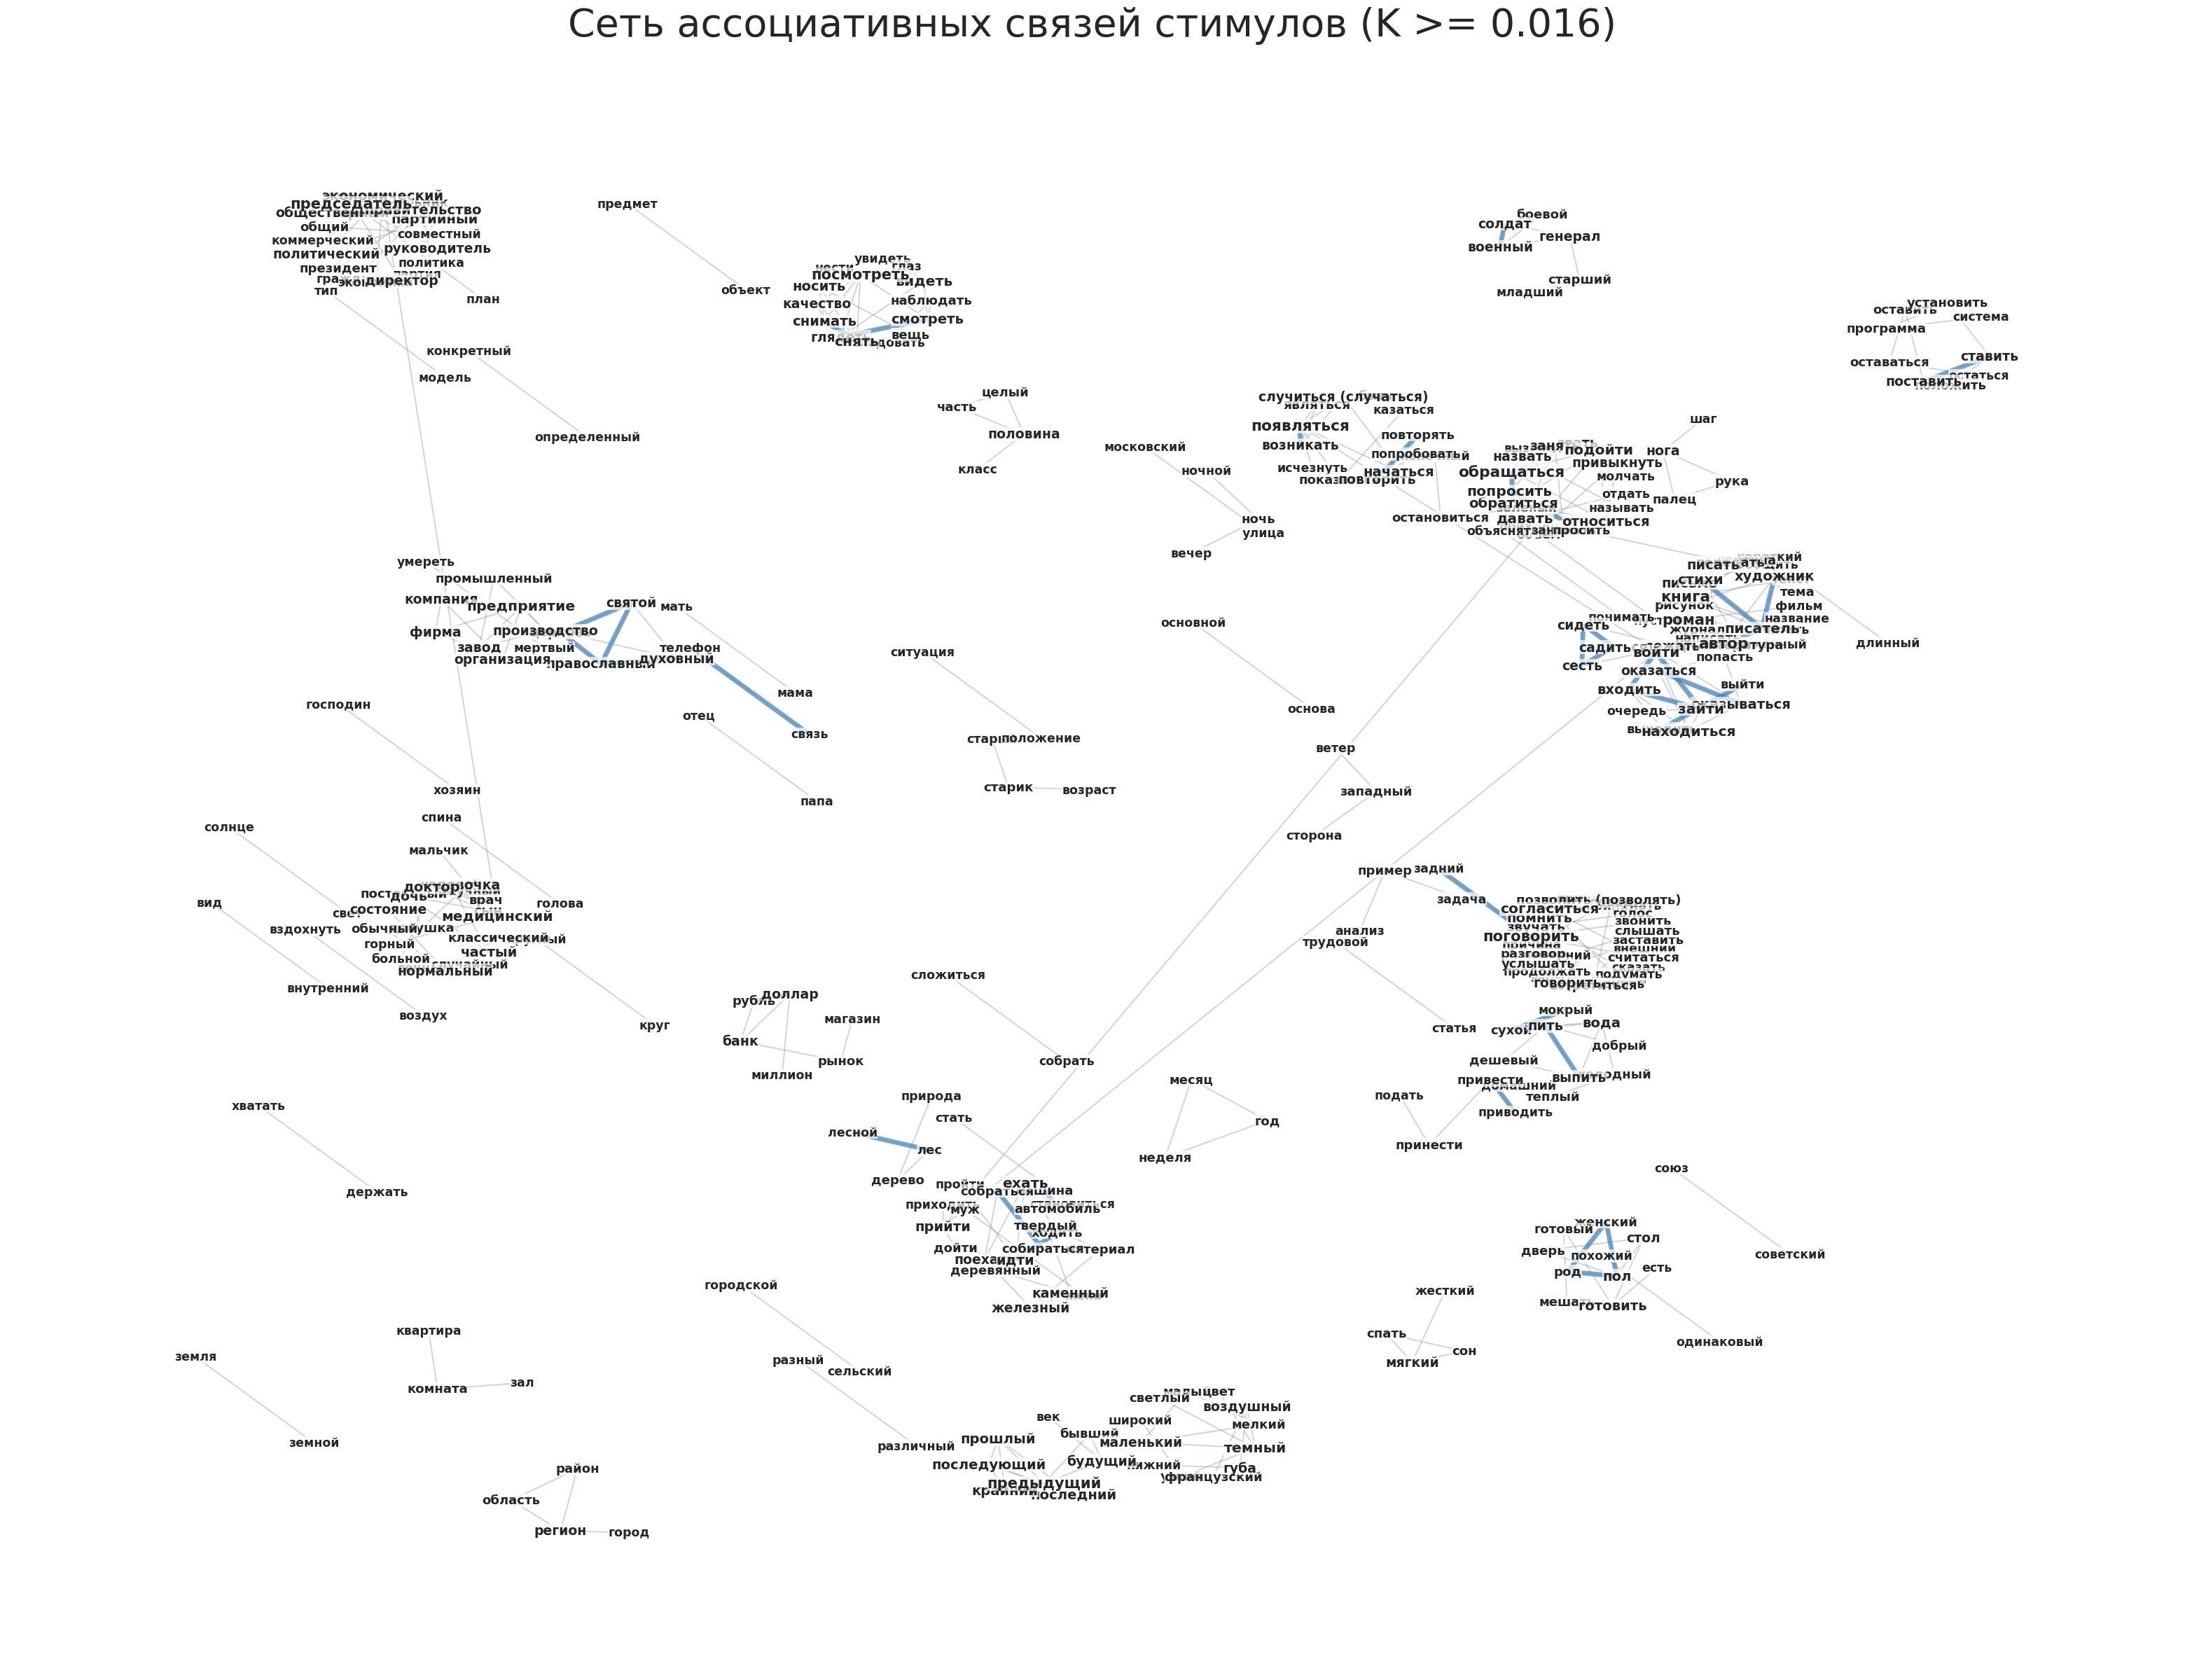

In [ ]:
communities = list(nx.community.greedy_modularity_communities(G_final))

fig = plt.figure(figsize=(40, 30))
pos = {}
rng = np.random.default_rng(seed=42)
group_centers = {i: rng.uniform(-15, 15, size=2) for i in range(len(communities))}

for i, comm in enumerate(communities):
    subgraph = G_final.subgraph(comm)
    local_pos = nx.spring_layout(subgraph, k=3.0, iterations=200, seed=42)
    for node in comm:
        pos[node] = local_pos[node] + group_centers[i]

# ребра (слабые и сильные)
nx.draw_networkx_edges(G_final, pos, width=1.5, alpha=0.4, edge_color='#999999')

strong_edges = [(u, v) for u, v, d in G_final.edges(data=True) if d['weight'] > 0.045]
nx.draw_networkx_edges(G_final, pos, edgelist=strong_edges, width=5.0, alpha=0.7, edge_color='steelblue')

# узлы
# важные узлы поверх остальных
sorted_nodes = sorted(G_final.nodes(), key=lambda n: centrality_degree[n])

for node in sorted_nodes:
    x, y = pos[node]
    # размер шрифта зависит от центральности
    font_sz = 12 + (centrality_degree[node] * 180)

    plt.text(x, y, s=node,
             fontsize=min(font_sz, 26),
             fontweight='bold',
             ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.3))

plt.axis('off')
plt.title(f"Сеть ассоциативных связей стимулов (K >= {threshold_k})", fontsize=40, pad=20)


fig.savefig('graph_final.png', dpi=300, bbox_inches='tight')
fig.savefig('graph_final.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# функция для поиска по графу общих лемм-ассоциаций для двух стимулов
def general_lemmas(stim1, stim2, shared_df):

    # по shared_df ищем строки, где оба стимула указаны в списке
    mask = shared_df['список стимулов'].apply(lambda x: stim1 in x and stim2 in x)
    common_lemmas = shared_df[mask].copy()

    if common_lemmas.empty:
        print(f"Общих лемм между '{stim1}' and '{stim2}' в этой таблице не найдено.")
        return

    print(f"Семантический мост: между {stim1} и {stim2}")
    print(f"Всего общих лемм-ассоциаций: {len(common_lemmas)}")

    print("\nОбщие ассоциации:")
    print(", ".join(common_lemmas['лемма'].tolist()))


general_lemmas('папа', 'мама', shared_lemmas)

Семантический мост: между папа и мама
Всего общих лемм-ассоциаций: 34

Общие ассоциации:
человек, дом, хороший, мой, семья, любовь, родной, главный, мама, помощь, любимый, рядом, добрый, радость, спокойствие, защита, злой, любить, родитель, поддержка, добро, уважение, детство, тепло, забота, папа, опора, сложность, доверие, нежность, веселие, воспитание, надежность, доброта


In [ ]:
# топ-5 групп
for i, comm in enumerate(communities[:5], 1):
    print(f"Группа {i} ({len(comm)} слов):")
    print(", ".join(sorted(list(comm))))


Группа 1 (28 слов):
внешний, встретиться, говорить, голос, договор, забыть, заставить, звонить, звучать, кивнуть, память, повод, поговорить, подумать, позволить (позволять), позвонить, помнить, принимать, принять, причина, продолжать, разговор, сказать, слушать, слышать, согласиться, считаться, услышать
Группа 2 (21 слов):
автор, журнал, картина, книга, литература, название, написать, передать, писатель, писать, письмо, рисунок, роман, современный, сообщить, стихи, текст, тема, фильм, художник, читать
Группа 3 (18 слов):
гражданин, директор, коммерческий, министр, начальник, общественный, общий, партийный, партия, политика, политический, правительство, председатель, президент, руководитель, совместный, экономика, экономический
Группа 4 (17 слов):
вызывать, давать, занимать, занять, звать, молчать, назвать, называть, обратиться, обращаться, отдать, относиться, подойти, попросить, привыкнуть, приходиться, просить
Группа 5 (15 слов):
больной, вечный, врач, горный, доктор, классический, ме

In [ ]:
final_file = 'БД ассоциаций_итог.xlsx'

with pd.ExcelWriter(final_file, engine='openpyxl') as writer:
    df2.to_excel(writer, sheet_name='1.Базовый список', index=False)
    df_summary.to_excel(writer, sheet_name='2.Сводная статистика', index=False)
    df_lemmas.to_excel(writer, sheet_name='3.Частоты лемм', index=False)
    df_strongest.to_excel(writer, sheet_name='4.Ядерные ассоциации', index=False)
    shared_lemmas.to_excel(writer, sheet_name='5.Пересечения лемм', index=False)
    df_tfidf.to_excel(writer, sheet_name='6.TF_IDF', index=False)
    df_graph_metrics.to_excel(writer, sheet_name='7.Сетевой анализ', index=False)

